# 2D Nuclear Segmentation with RetinaNet

In [1]:
import os
import errno

import numpy as np

import deepcell

Using TensorFlow backend.


In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (5760, 216, 256, 1)
y.shape: (5760, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# NOTE: Change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'retinanet_model'
backbone = 'vgg16'  # vgg16, vgg19, resnet50, densenet121, densenet169, densenet201

n_epoch = 10  # Number of training epochs
test_size = .10  # % of data saved as test
lr = 1e-5

optimizer = Adam(lr=lr, clipnorm=0.001)

lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 32

num_classes = 1  # "object" is the only class

## Create the RetinaNet Model

In [6]:
from deepcell import model_zoo

# training model is `retinanet` while prediction model is `retinanet_bbox`
model = model_zoo.RetinaNet(
    backbone=backbone,  
    input_shape=X_train.shape[1:],
    num_classes=num_classes)

In [7]:
from deepcell.training import train_model_retinanet

# TODO: rotation_range and zoom_range will cause poor training results

model = train_model_retinanet(
    model=model,
    backbone=backbone,
    dataset=DATA_FILE,  # full path to npz file
    model_name='retinanet',
    sigma=3.0,
    alpha=0.25,
    gamma=2.0,
    weighted_average=True,
    score_threshold=0.01,
    iou_threshold=0.5,
    max_detections=100,
    test_size=test_size,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=0,#180,
    flip=True,
    shear=False,
    zoom_range=0)#(0.8, 1.2))

X_train shape: (6480, 216, 256, 1)
y_train shape: (6480, 216, 256, 1)
X_test shape: (720, 216, 256, 1)
y_test shape: (720, 216, 256, 1)
Output Shape: (None, None, 1)
Number of Classes: 1
Training on 1 GPUs
Epoch 1/10
180/181 [============================>.] - ETA: 0s - loss: 3.0800 - regression_loss: 2.3296 - classification_loss: 0.7504
Epoch 00001: val_loss improved from inf to 2.59283, saving model to /data/models/retinanet.h5
4843 instances of class 0 with average precision: 0.0651
mAP: 0.0651
181/181 [==============================] - 88s 485ms/step - loss: 3.0774 - regression_loss: 2.3286 - classification_loss: 0.7488 - val_loss: 2.5928 - val_regression_loss: 2.0993 - val_classification_loss: 0.4935
Epoch 2/10
180/181 [============================>.] - ETA: 0s - loss: 2.0315 - regression_loss: 1.6624 - classification_loss: 0.3691
Epoch 00002: val_loss improved from 2.59283 to 1.57731, saving model to /data/models/retinanet.h5
4843 instances of class 0 with average precision: 0.563

In [8]:
# Set up the prediction model
from deepcell.model_zoo.retinanet import retinanet_bbox

# TODO: class_specific_filter=True breaks
prediction_model = retinanet_bbox(model, nms=True, class_specific_filter=False)
prediction_model.load_weights('/data/models/retinanet.h5')

# ValueError: Cannot use 'filtered_detections/map/while/strided_slice_1'
# as input to 'filtered_detections/map/while/ones/packed' because
# 'filtered_detections/map/while/strided_slice_1' is in a while loop.

# filtered_detections/map/while/ones/Less while context: None
# filtered_detections/map/while/strided_slice_1 while context:
#     filtered_detections/map/while/while_context

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image Number: 1040


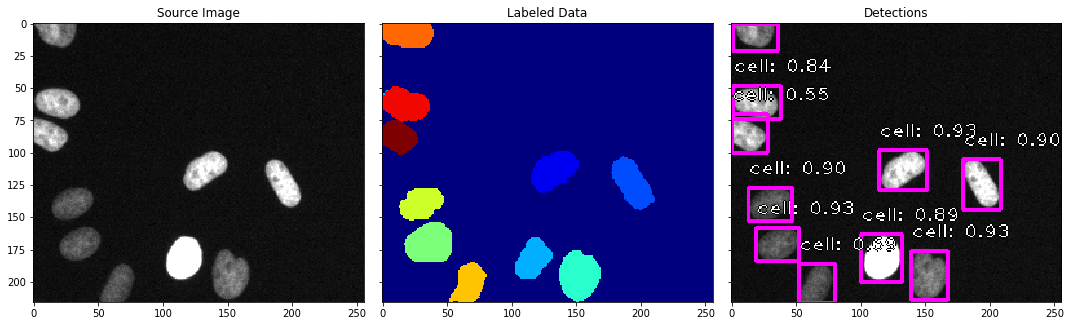

In [10]:
import matplotlib.pyplot as plt
import os
import time

import numpy as np

from deepcell.utils.plot_utils import draw_detections

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image Number:', index)

image, mask = X_test[index:index + 1], y_test[index:index + 1]

boxes, scores, labels = prediction_model.predict(image)

image = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
mask = np.squeeze(mask)

# copy to draw on
draw = image.copy()

# draw the detections
draw_detections(draw, boxes[0], scores[0], labels[0],
                label_to_name=lambda x: 'cell',
                score_threshold=0.5,)

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap='jet')
ax[0].set_title('Source Image')

ax[1].imshow(mask, cmap='jet')
ax[1].set_title('Labeled Data')

ax[2].imshow(draw, cmap='jet')
ax[2].set_title('Detections')

fig.tight_layout()
plt.show()